In [19]:
import models
import datasets
import loss_functions
import networks

import time
import numpy as np
import random
import os
import matplotlib.pyplot as plt

import torch

from importlib import reload
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

In [2]:
networks = reload(networks)


In [3]:
from numpy.linalg import norm
def euclidean_disance(x, y):
    return norm(x - y)


def most_common(arr):
    counts = np.bincount(arr)
    return np.argmax(counts)

In [4]:
def count_classes(images):
    positive, negative = 0, 0
    for image in images:
        if image.__contains__("False"):
            negative = negative + 1
        else:
            positive = positive + 1
    print("Positive = {}\nNegative = {}".format(positive,negative))


In [5]:
def predict_label(encoding, encodings, labels, k):
    distances = np.zeros(len(encodings))
    for indx, x in enumerate(encodings, 0):
        distance = euclidean_disance(encoding, x)
        distances[indx] = distance

    zipped = list(zip(encodings, distances, labels))
    zipped.sort(key=lambda t: t[1])
    zipped = zipped[1:k + 1]
    labels = np.array(zipped)[:, 2].astype(int)
    result = most_common(labels)
    return result

In [6]:
def plot_results(encodings, labels):
    color = ['blue' if label == 0 else 'red' for label in labels]
    plt.scatter(encodings[:, 0], encodings[:, 1], c=color)
    plt.xlabel("dim1")
    plt.ylabel("dim2")
    plt.show()

In [7]:
def print_scores(labels, predicted_labels):
    print("Accuracy: {}".format(accuracy_score(labels, predicted_labels)))
    print("Precision: {}".format(precision_score(labels, predicted_labels)))
    print("Recall: {}".format(recall_score(labels, predicted_labels)))
    print("F1: {}".format(f1_score(labels, predicted_labels)))

In [8]:
def print_conf_matrix(labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(labels, predicted_labels).ravel()
    print("tn: {}\nfp: {}\nfn: {}\ntp: {}\n".format(tn,fp,fn,tp))

In [9]:
def plot_loss(loss_history):
    plt.xlabel("batch")
    plt.ylabel("loss")
    plt.plot(loss_history)
    plt.show()

In [12]:
def undersample(images):
    false_images = []
    true_images = []
    for image in images:
        false_images.append(image) if image.__contains__("False") else true_images.append(image)

    images = []
    if len(false_images) > len(true_images):
        false_images = false_images[0:len(true_images)]
        images = false_images
        images.extend(true_images)
        
    else:
        true_images = true_images[0:len(false_images)]
        images = true_images
        images.extend(false_images)
        
    return images

In [10]:
def eval_model(model, dataloader_train, dataloader_test):
    encodings, labels = model.predict(dataloader_train)
    plot_results(encodings, labels)
    
    encodings, labels = model.predict(dataloader_test)
    plot_results(encodings, labels)
    
    predicted_labels = []
    for encoding, label in (zip(encodings, labels)):
        predicted_labels.append(predict_label(encoding, encodings, labels, 3))

    predicted_labels = np.array(predicted_labels)
    print_conf_matrix(labels, predicted_labels)
    print_scores(labels, predicted_labels)

In [11]:
def validation(model, data, batch_size, path, split_factor=0.2):
        data = np.array(data)
        train, test = train_test_split(data, test_size=split_factor)
        dataset_train = datasets.SiameseDataset(path, train)
        dataset_test = datasets.SiameseDataset(path, test)
        dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=batch_size, drop_last=True)
        loss_history = model.fit(dataloader_train)
        plot_loss(loss_history)
        dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=batch_size, drop_last=False)
        dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=batch_size, drop_last=False)
        eval_model(model, dataloader_train_eval, dataloader_test_eval)

In [13]:
def k_cross_validation(model, data, batch_size, path, k=5):
    data = np.array(data)
    kf = KFold(n_splits=k)
    torch.save(model.network,'./net')
    nfold = 1
    for train, test in kf.split(data):
        print("############### Fold number {} ###############\n".format(nfold))
        dataset_train = datasets.SiameseDataset(path, data[train])
        dataset_test = datasets.SiameseDataset(path, data[test])
        dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=batch_size, drop_last=True)
        loss_history = model.fit(dataloader_train)
        plot_loss(loss_history)
        dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=batch_size, drop_last=False)
        dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=batch_size, drop_last=False)
        eval_model(model, dataloader_train_eval, dataloader_test_eval)
        model.network = torch.load('./net')
        nfold = nfold + 1


# T2

In [31]:
path = '../Data/t2_tra_np_norm'
images = os.listdir(path)
random.shuffle(images)


In [32]:
len(images)


344

In [33]:
count_classes(images)

Positive = 79
Negative = 265


In [34]:
networks = reload(networks)

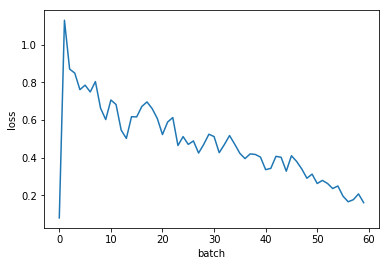

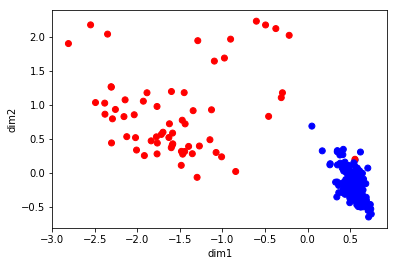

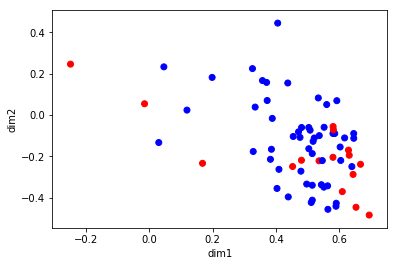

tn: 44
fp: 9
fn: 15
tp: 9

Accuracy: 0.6521739130434783
Precision: 0.1
Recall: 0.0625
F1: 0.07692307692307693


In [37]:
model = models.SiameseModel(1, 0.0001, networks.SiameseNet(networks.Net2DChannel1()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

############### Fold number 1 ###############



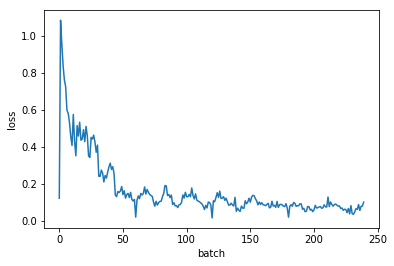

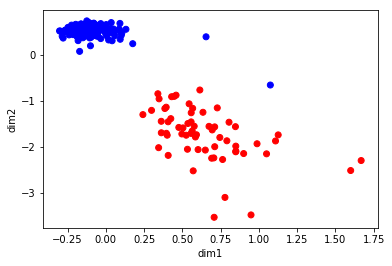

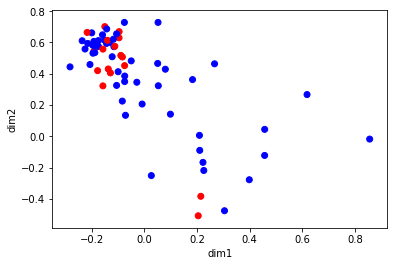

Accuracy: 0.6666666666666666
Precision: 0.25
Recall: 0.17647058823529413
F1: 0.20689655172413793
############### Fold number 2 ###############



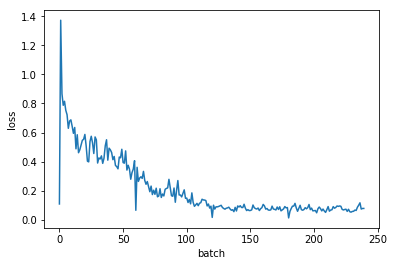

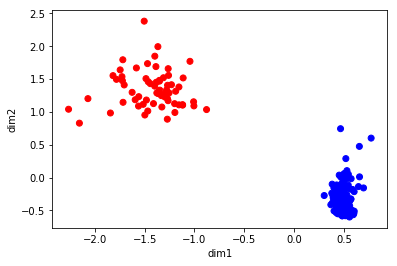

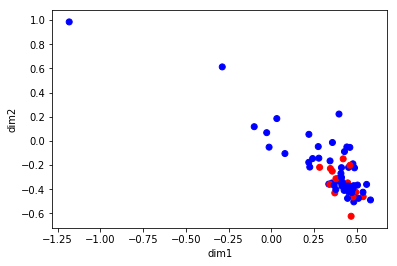

Accuracy: 0.7681159420289855
Precision: 0.3333333333333333
Recall: 0.14285714285714285
F1: 0.2
############### Fold number 3 ###############



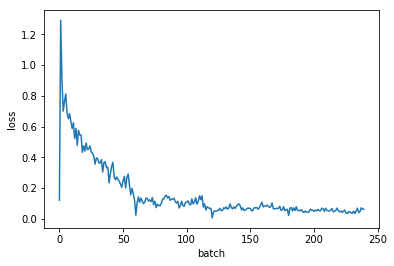

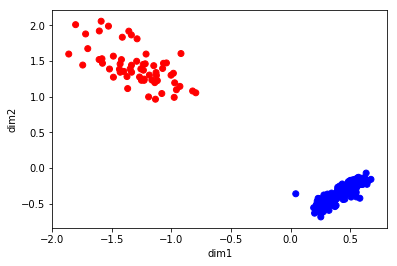

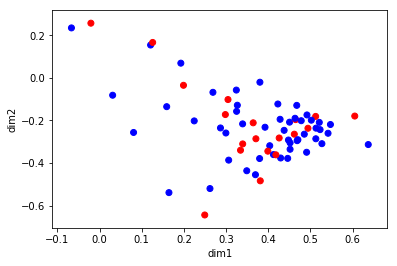

Accuracy: 0.5942028985507246
Precision: 0.15384615384615385
Recall: 0.10526315789473684
F1: 0.125
############### Fold number 4 ###############



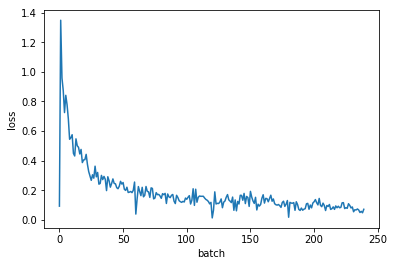

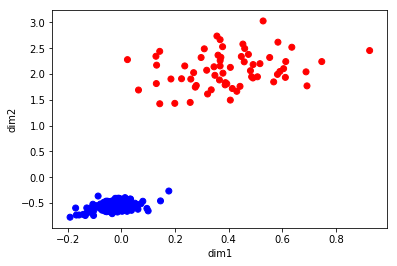

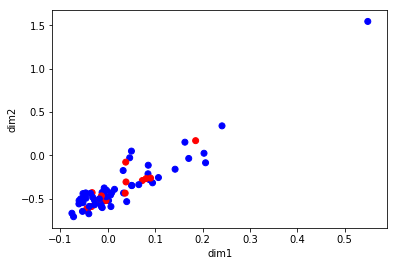

Accuracy: 0.782608695652174
Precision: 0.42857142857142855
Recall: 0.21428571428571427
F1: 0.2857142857142857
############### Fold number 5 ###############



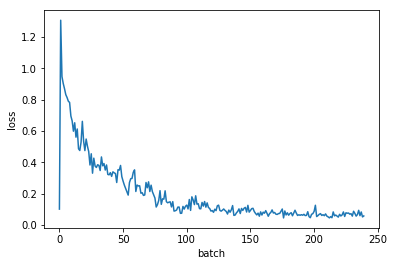

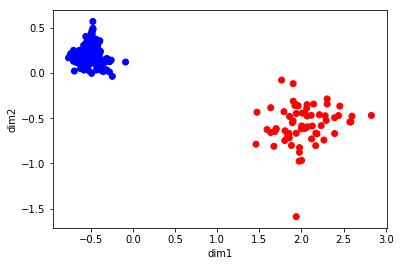

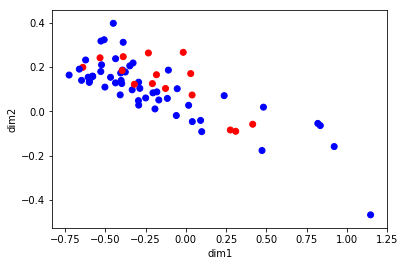

Accuracy: 0.7352941176470589
Precision: 0.3333333333333333
Recall: 0.2
F1: 0.25


In [17]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel1()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# Diff

In [71]:
path = '../Data/diff_ADC_BVAL_np_norm'
images = os.listdir(path)
random.shuffle(images)

In [72]:
len(images)

314

In [73]:
count_classes(images)

Positive = 70
Negative = 244


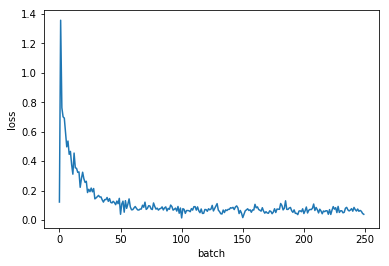

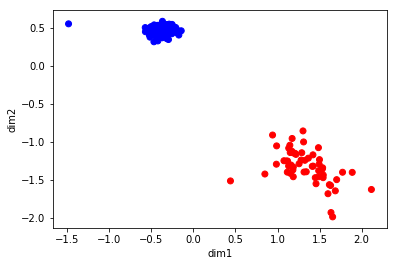

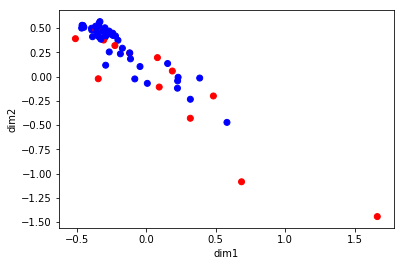

Accuracy: 0.7301587301587301
Precision: 0.2857142857142857
Recall: 0.14285714285714285
F1: 0.19047619047619047


In [38]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

############### Fold number 1 ###############



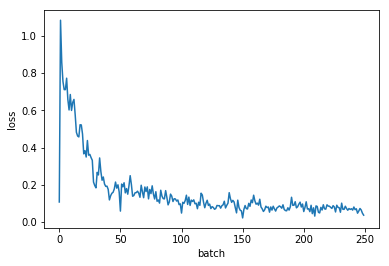

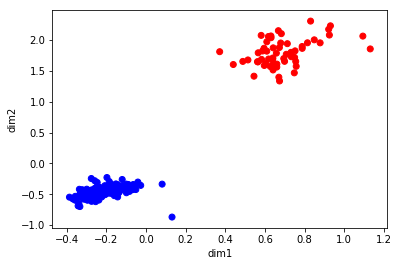

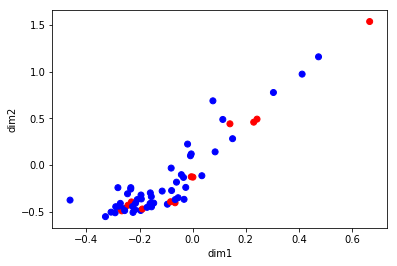

Accuracy: 0.6984126984126984
Precision: 0.25
Recall: 0.23076923076923078
F1: 0.24000000000000002
############### Fold number 2 ###############



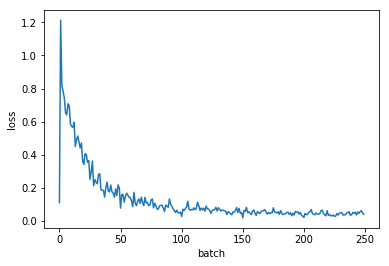

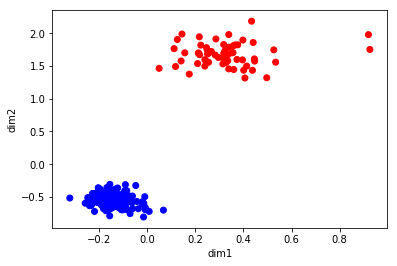

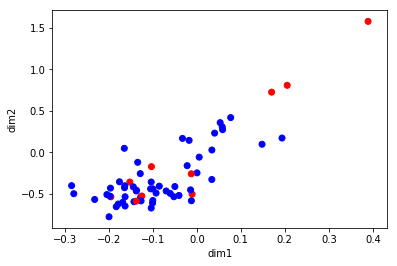

Accuracy: 0.8253968253968254
Precision: 0.3333333333333333
Recall: 0.1
F1: 0.15384615384615383
############### Fold number 3 ###############



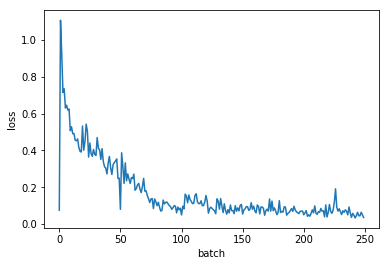

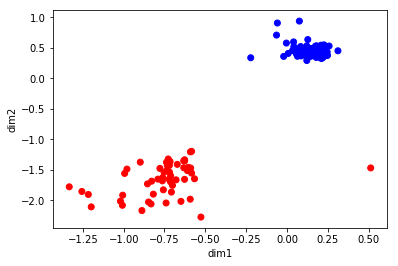

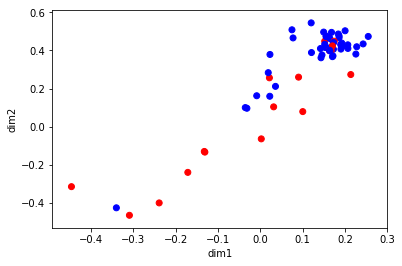

Accuracy: 0.7301587301587301
Precision: 0.5
Recall: 0.4117647058823529
F1: 0.45161290322580644
############### Fold number 4 ###############



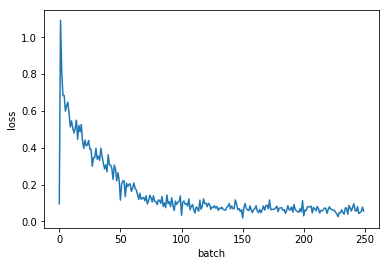

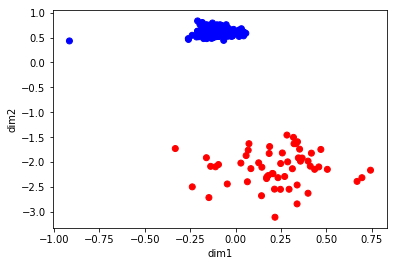

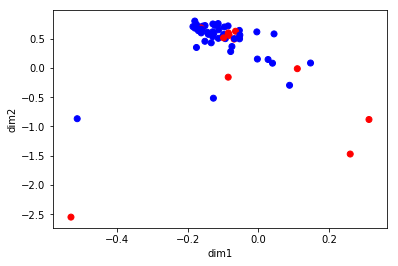

Accuracy: 0.746031746031746
Precision: 0.36363636363636365
Recall: 0.3076923076923077
F1: 0.33333333333333337
############### Fold number 5 ###############



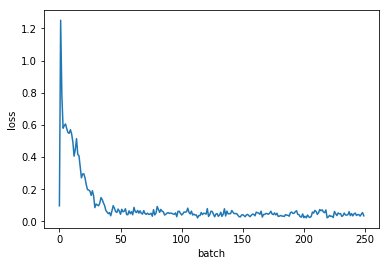

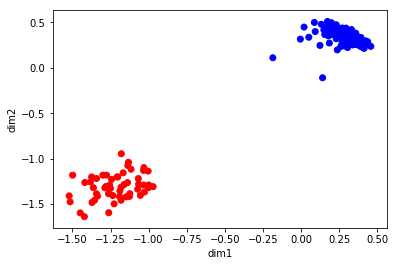

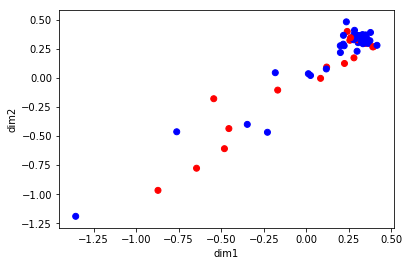

Accuracy: 0.6774193548387096
Precision: 0.38461538461538464
Recall: 0.29411764705882354
F1: 0.33333333333333337


In [39]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# T2 3D

In [15]:
path = '../Data/t2_tra_np_3D_norm'
images = os.listdir(path)
random.shuffle(images)


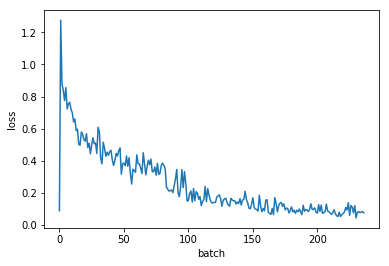

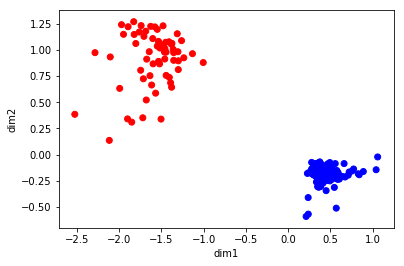

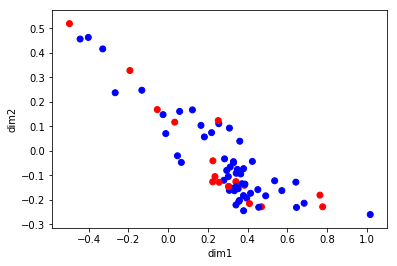

Accuracy: 0.6811594202898551
Precision: 0.2727272727272727
Recall: 0.17647058823529413
F1: 0.21428571428571427


In [18]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel1()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 48, path)

############### Fold number 1 ###############



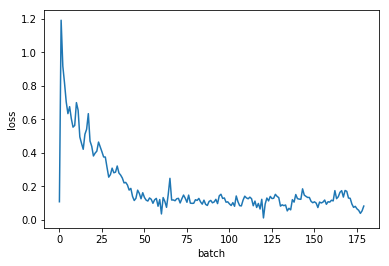

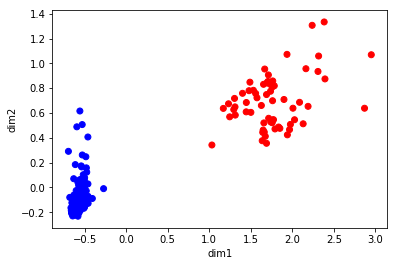

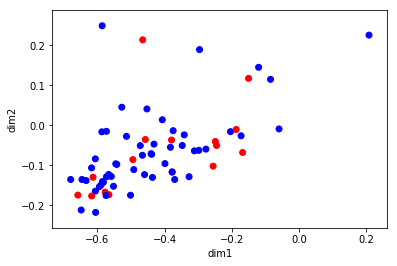

Accuracy: 0.6811594202898551
Precision: 0.125
Recall: 0.0625
F1: 0.08333333333333333
############### Fold number 2 ###############



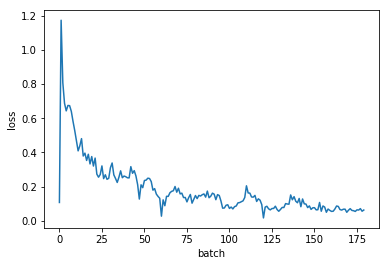

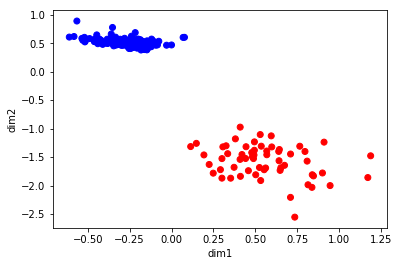

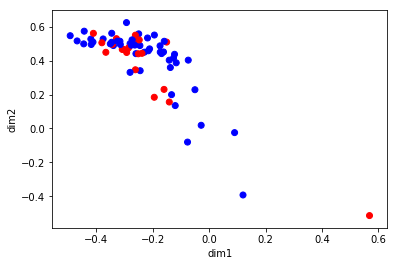

Accuracy: 0.6811594202898551
Precision: 0.42857142857142855
Recall: 0.3
F1: 0.3529411764705882
############### Fold number 3 ###############



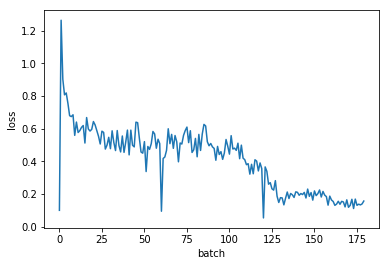

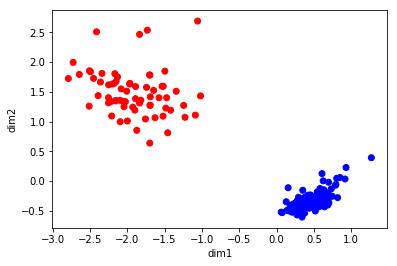

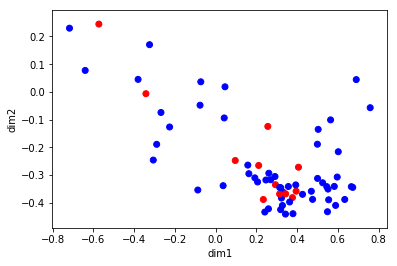

Accuracy: 0.7971014492753623
Precision: 0.25
Recall: 0.08333333333333333
F1: 0.125
############### Fold number 4 ###############



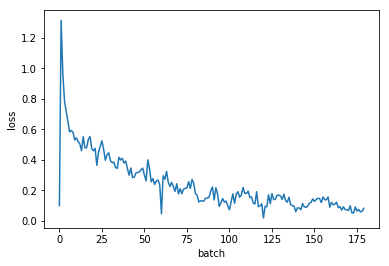

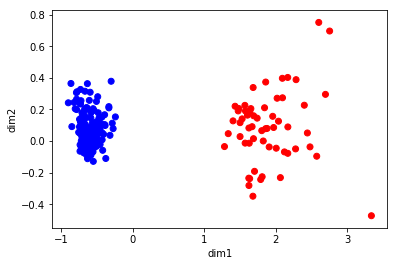

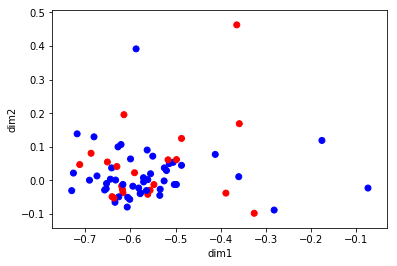

Accuracy: 0.6086956521739131
Precision: 0.35
Recall: 0.3333333333333333
F1: 0.3414634146341463
############### Fold number 5 ###############



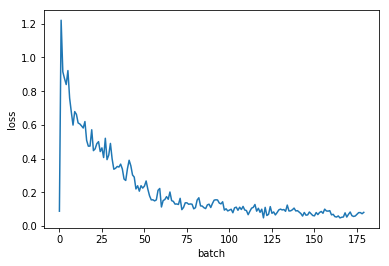

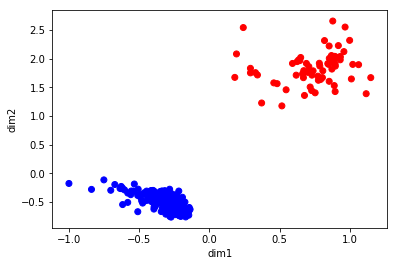

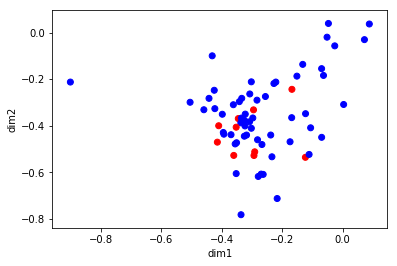

Accuracy: 0.8382352941176471
Precision: 0.0
Recall: 0.0
F1: 0.0


In [19]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel1()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# Diff 3D

In [38]:
path = '../Data/diff_ADC_BVAL_np_3D_norm'
images = os.listdir(path)
random.shuffle(images)


In [39]:
networks = reload(networks)

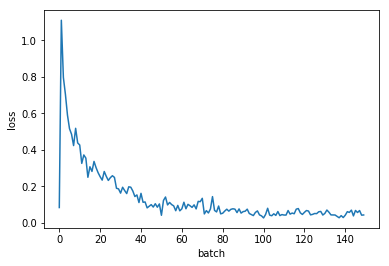

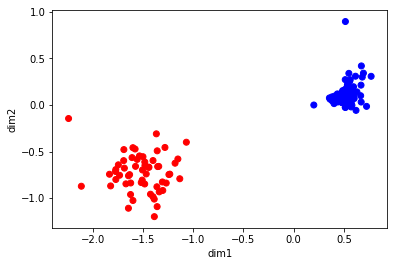

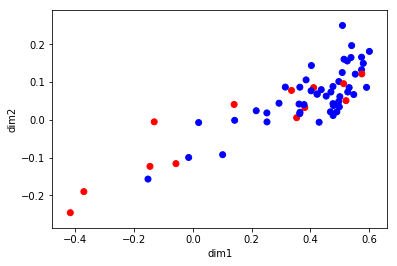

tn: 47
fp: 3
fn: 9
tp: 3

Accuracy: 0.8095238095238095
Precision: 0.5714285714285714
Recall: 0.3076923076923077
F1: 0.4


In [40]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel2()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

############### Fold number 1 ###############



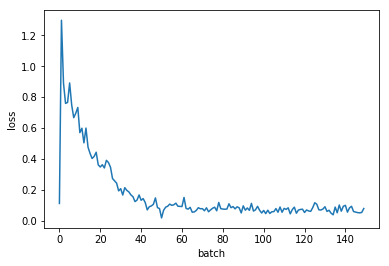

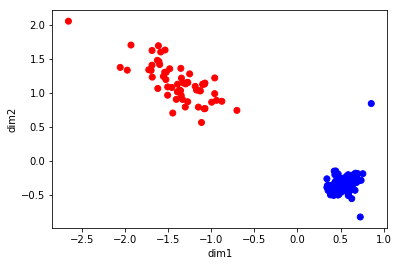

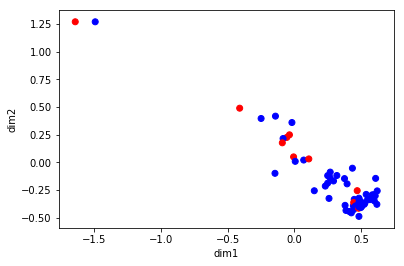

tn: 48
fp: 5
fn: 7
tp: 5

Accuracy: 0.8095238095238095
Precision: 0.375
Recall: 0.3
F1: 0.33333333333333326
############### Fold number 2 ###############



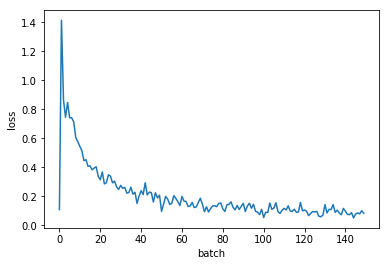

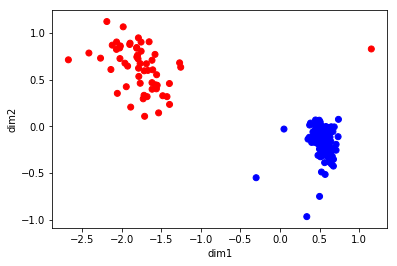

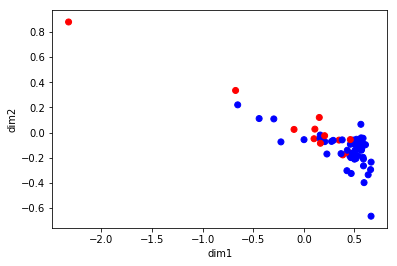

tn: 42
fp: 8
fn: 12
tp: 8

Accuracy: 0.6825396825396826
Precision: 0.1111111111111111
Recall: 0.07692307692307693
F1: 0.09090909090909093
############### Fold number 3 ###############



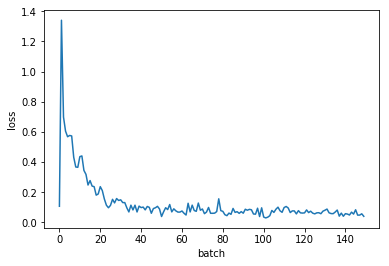

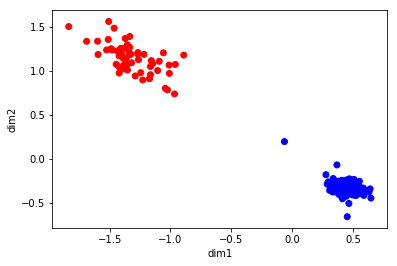

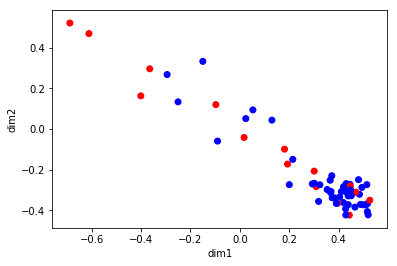

tn: 43
fp: 5
fn: 13
tp: 5

Accuracy: 0.7142857142857143
Precision: 0.2857142857142857
Recall: 0.13333333333333333
F1: 0.18181818181818182
############### Fold number 4 ###############



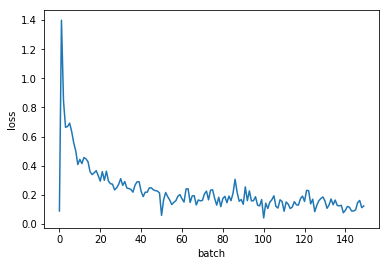

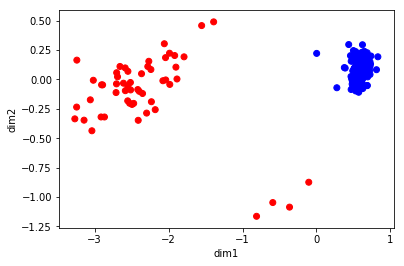

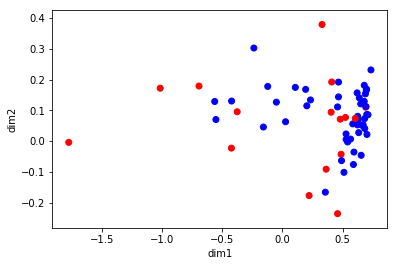

tn: 45
fp: 2
fn: 14
tp: 2

Accuracy: 0.746031746031746
Precision: 0.5
Recall: 0.125
F1: 0.2
############### Fold number 5 ###############



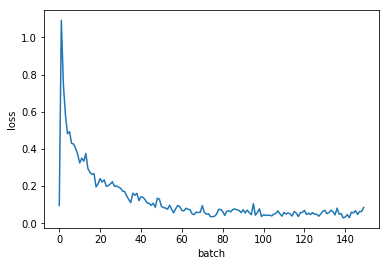

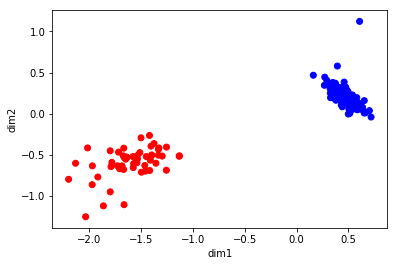

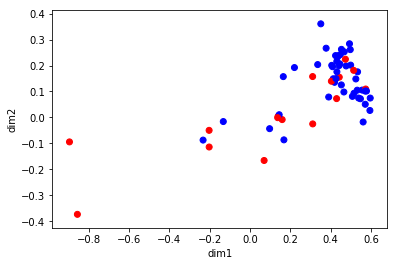

tn: 39
fp: 7
fn: 10
tp: 7

Accuracy: 0.7258064516129032
Precision: 0.46153846153846156
Recall: 0.375
F1: 0.41379310344827586


In [41]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel2()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# T2 Undersample

In [24]:
path = '../Data/t2_tra_np_norm'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)


In [25]:
len(images)

474

In [26]:
count_classes(images)

Positive = 237
Negative = 237


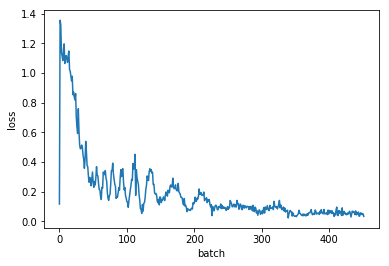

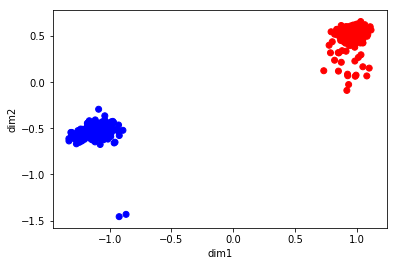

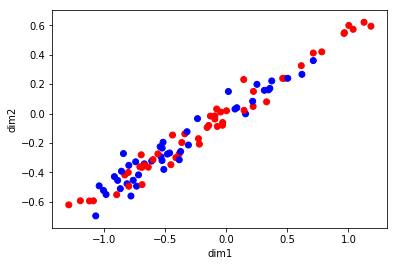

tn: 26
fp: 18
fn: 21
tp: 30

Accuracy: 0.5894736842105263
Precision: 0.625
Recall: 0.5882352941176471
F1: 0.6060606060606061
364.1761176586151


In [27]:
start = time.time()

model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel1()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

end = time.time()
print(end - start)

############### Fold number 1 ###############



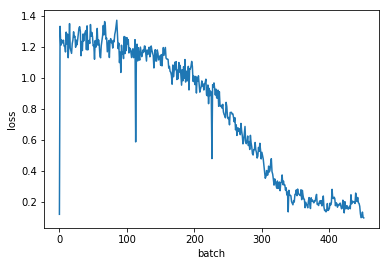

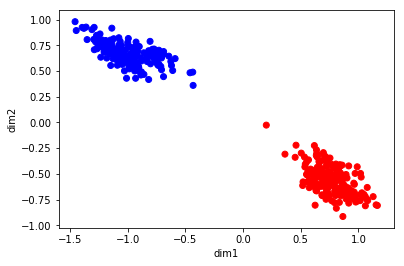

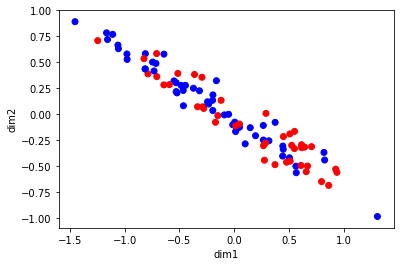

tn: 38
fp: 16
fn: 19
tp: 22

Accuracy: 0.631578947368421
Precision: 0.5789473684210527
Recall: 0.5365853658536586
F1: 0.5569620253164557
############### Fold number 2 ###############



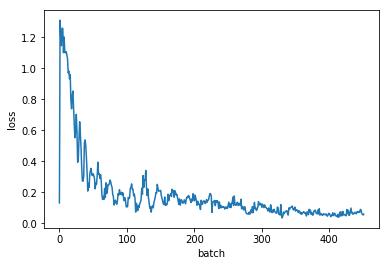

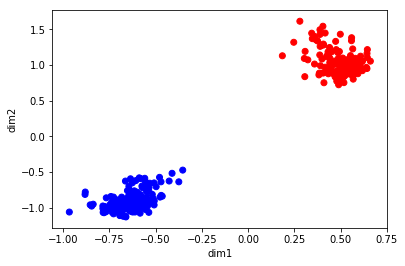

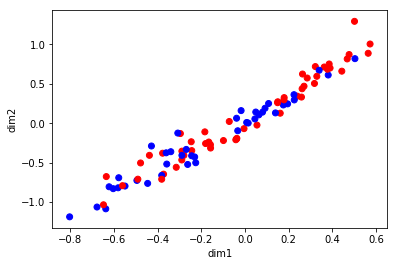

tn: 25
fp: 17
fn: 20
tp: 33

Accuracy: 0.6105263157894737
Precision: 0.66
Recall: 0.6226415094339622
F1: 0.6407766990291262
############### Fold number 3 ###############



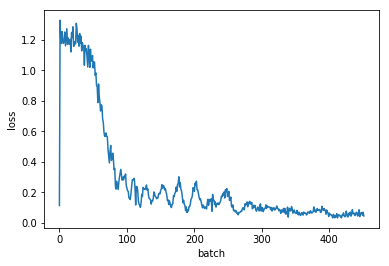

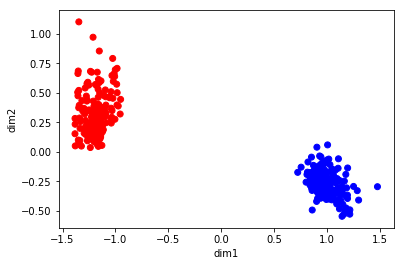

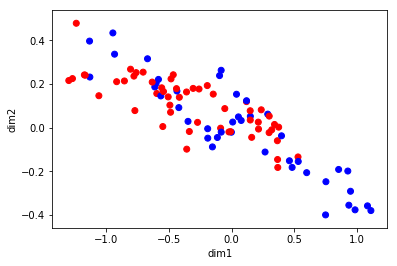

tn: 24
fp: 18
fn: 12
tp: 41

Accuracy: 0.6842105263157895
Precision: 0.6949152542372882
Recall: 0.7735849056603774
F1: 0.7321428571428573
############### Fold number 4 ###############



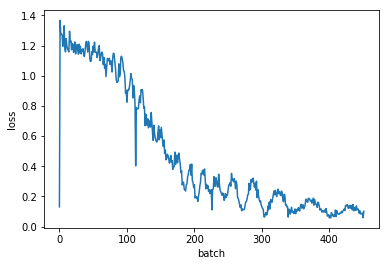

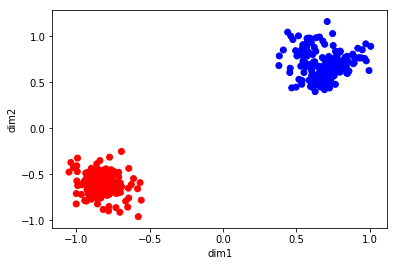

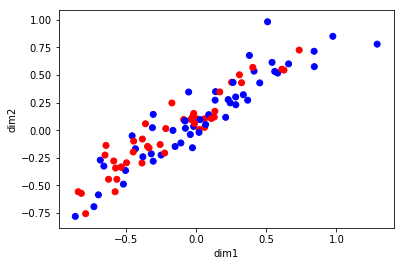

tn: 23
fp: 28
fn: 21
tp: 23

Accuracy: 0.4842105263157895
Precision: 0.45098039215686275
Recall: 0.5227272727272727
F1: 0.48421052631578954
############### Fold number 5 ###############



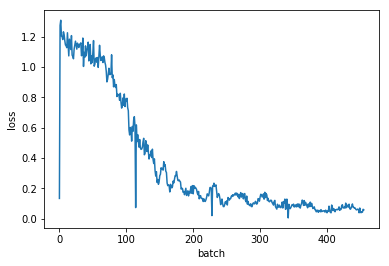

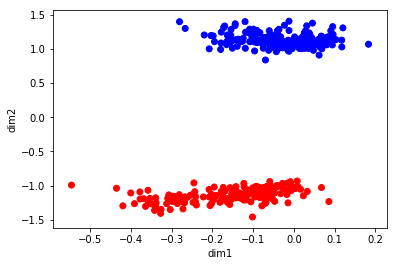

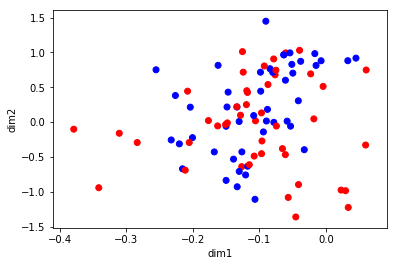

tn: 23
fp: 25
fn: 28
tp: 18

Accuracy: 0.43617021276595747
Precision: 0.4186046511627907
Recall: 0.391304347826087
F1: 0.4044943820224719


In [28]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel1()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# Diff Undersample

In [29]:
path = '../Data/diff_ADC_BVAL_np_norm'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)



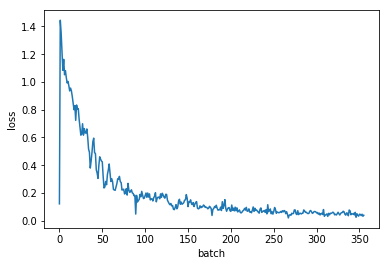

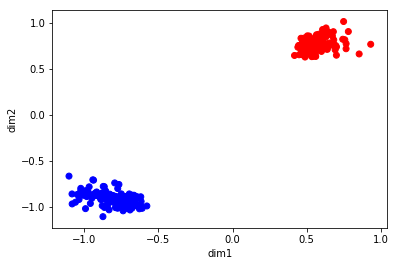

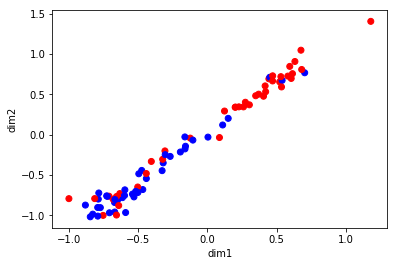

tn: 27
fp: 15
fn: 15
tp: 27

Accuracy: 0.6428571428571429
Precision: 0.6428571428571429
Recall: 0.6428571428571429
F1: 0.6428571428571429


In [30]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

############### Fold number 1 ###############



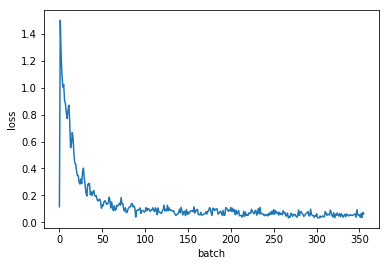

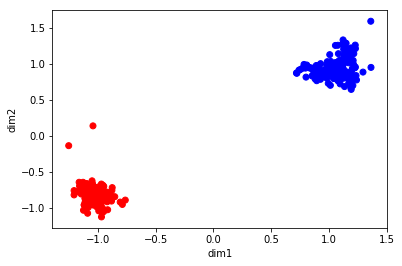

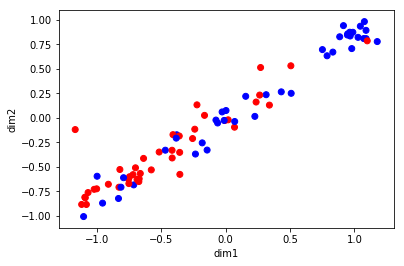

tn: 28
fp: 14
fn: 9
tp: 33

Accuracy: 0.7261904761904762
Precision: 0.7021276595744681
Recall: 0.7857142857142857
F1: 0.7415730337078651
############### Fold number 2 ###############



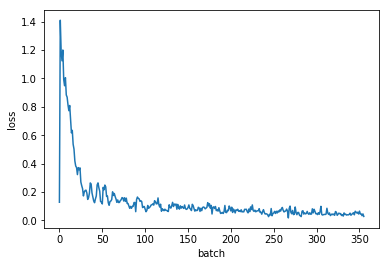

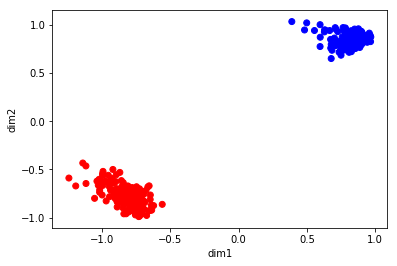

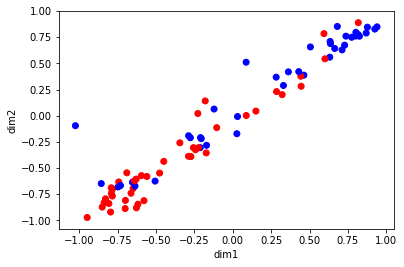

tn: 28
fp: 12
fn: 14
tp: 30

Accuracy: 0.6904761904761905
Precision: 0.7142857142857143
Recall: 0.6818181818181818
F1: 0.6976744186046512
############### Fold number 3 ###############



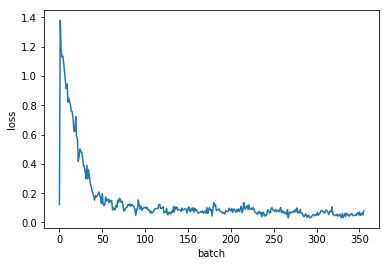

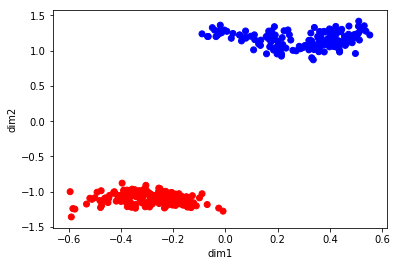

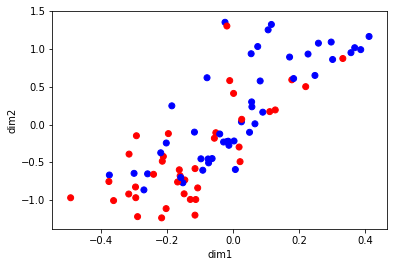

tn: 32
fp: 14
fn: 21
tp: 17

Accuracy: 0.5833333333333334
Precision: 0.5483870967741935
Recall: 0.4473684210526316
F1: 0.49275362318840576
############### Fold number 4 ###############



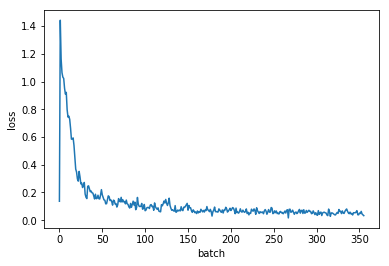

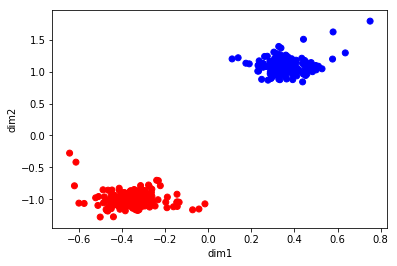

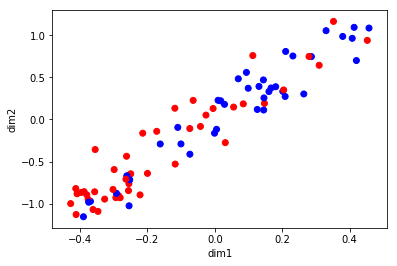

tn: 26
fp: 13
fn: 15
tp: 30

Accuracy: 0.6666666666666666
Precision: 0.6976744186046512
Recall: 0.6666666666666666
F1: 0.6818181818181818
############### Fold number 5 ###############



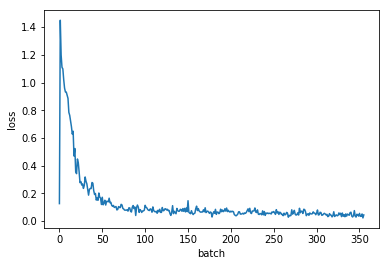

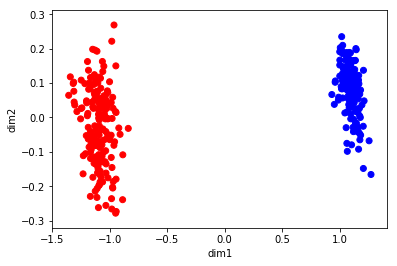

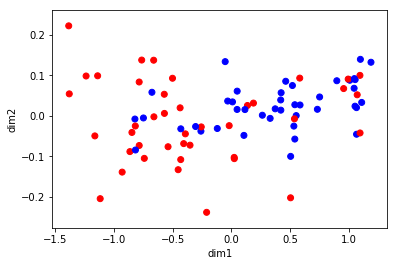

tn: 34
fp: 9
fn: 15
tp: 26

Accuracy: 0.7142857142857143
Precision: 0.7428571428571429
Recall: 0.6341463414634146
F1: 0.6842105263157895


In [31]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# T2 3D Undersample

In [32]:
path = '../Data/t2_tra_np_3D_norm'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)

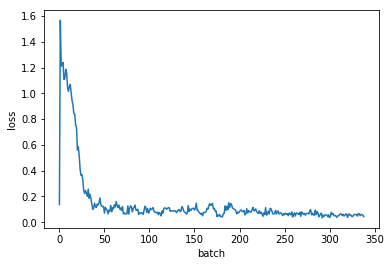

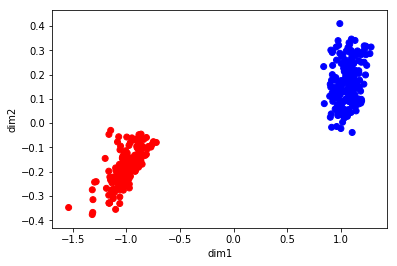

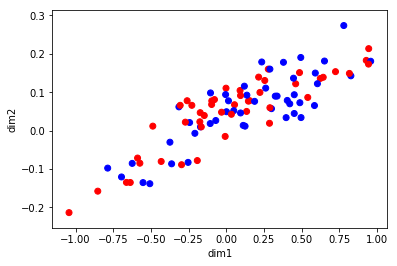

tn: 15
fp: 33
fn: 25
tp: 22

Accuracy: 0.3894736842105263
Precision: 0.4
Recall: 0.46808510638297873
F1: 0.43137254901960786


In [33]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel1()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

############### Fold number 1 ###############



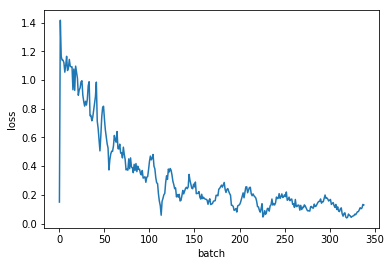

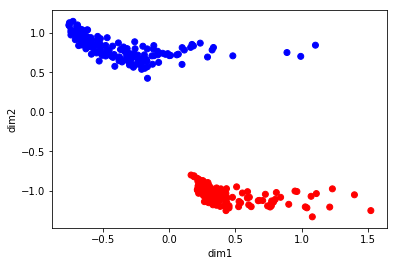

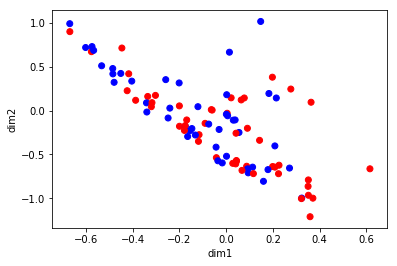

tn: 25
fp: 21
fn: 24
tp: 25

Accuracy: 0.5263157894736842
Precision: 0.5434782608695652
Recall: 0.5102040816326531
F1: 0.5263157894736842
############### Fold number 2 ###############



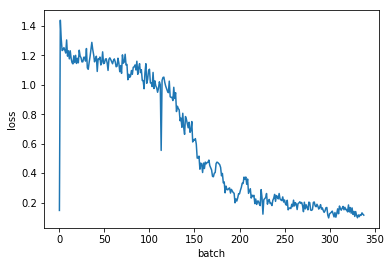

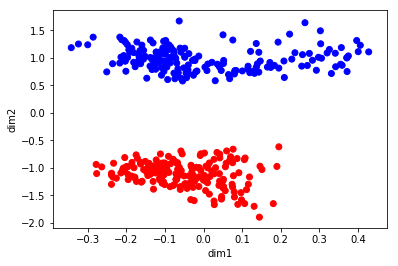

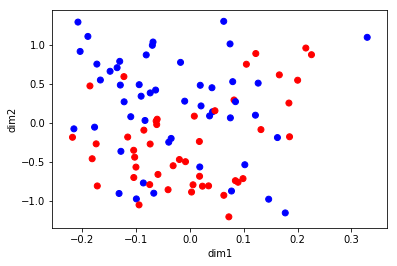

tn: 31
fp: 18
fn: 16
tp: 30

Accuracy: 0.6421052631578947
Precision: 0.625
Recall: 0.6521739130434783
F1: 0.6382978723404256
############### Fold number 3 ###############



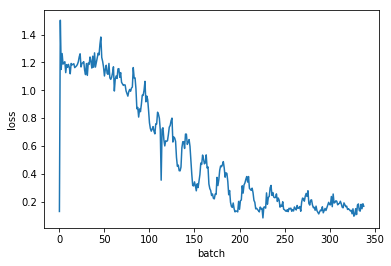

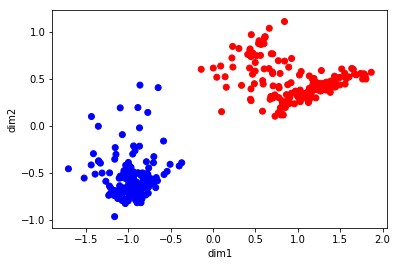

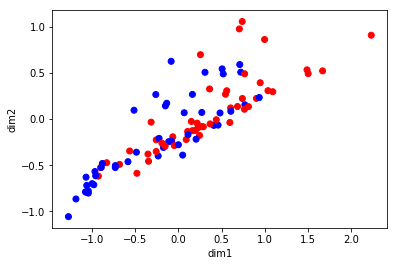

tn: 21
fp: 24
fn: 20
tp: 30

Accuracy: 0.5368421052631579
Precision: 0.5555555555555556
Recall: 0.6
F1: 0.576923076923077
############### Fold number 4 ###############



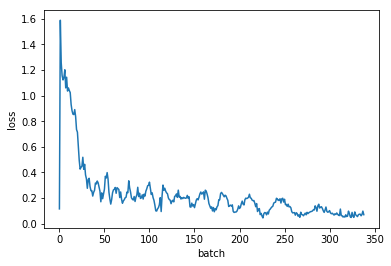

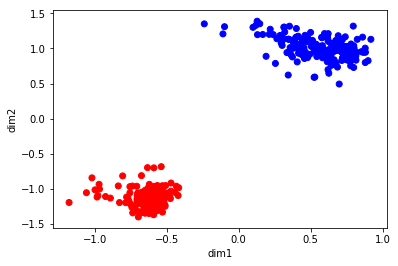

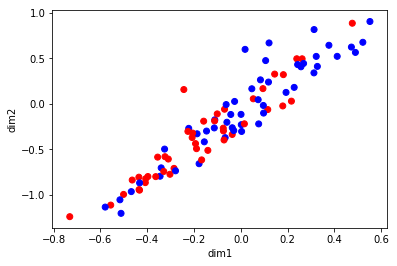

tn: 29
fp: 22
fn: 28
tp: 16

Accuracy: 0.47368421052631576
Precision: 0.42105263157894735
Recall: 0.36363636363636365
F1: 0.3902439024390244
############### Fold number 5 ###############



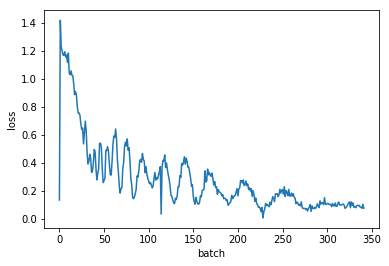

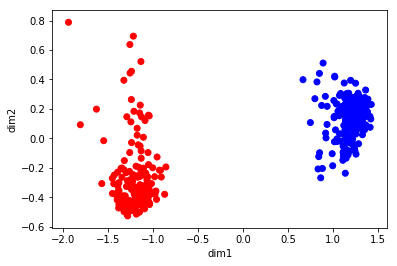

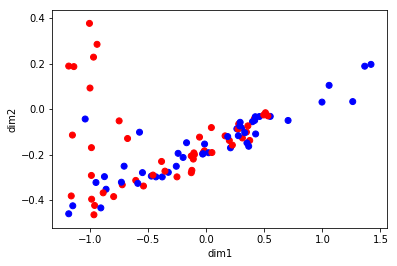

tn: 21
fp: 25
fn: 25
tp: 23

Accuracy: 0.46808510638297873
Precision: 0.4791666666666667
Recall: 0.4791666666666667
F1: 0.4791666666666667


In [34]:
model = models.SiameseModel(3, 0.0001, networks.SiameseNet(networks.Net3DChannel1()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)

# Diff 3D Undersample

In [38]:
path = '../Data/diff_ADC_BVAL_np_3D_norm'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)


In [40]:
len(images)

420

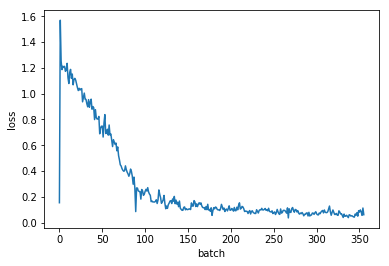

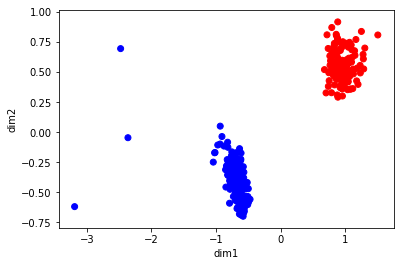

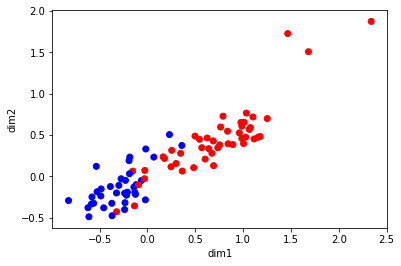

tn: 31
fp: 5
fn: 4
tp: 44

Accuracy: 0.8928571428571429
Precision: 0.8979591836734694
Recall: 0.9166666666666666
F1: 0.9072164948453607


In [36]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net3DChannel2()).cuda(), loss_functions.ContrastiveLoss())
validation(model, images, 64, path)

############### Fold number 1 ###############



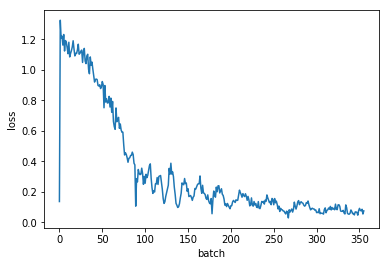

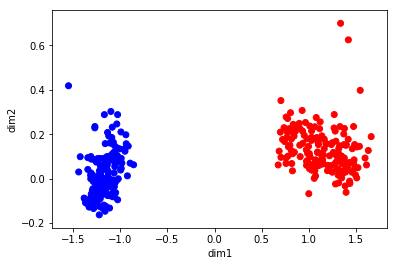

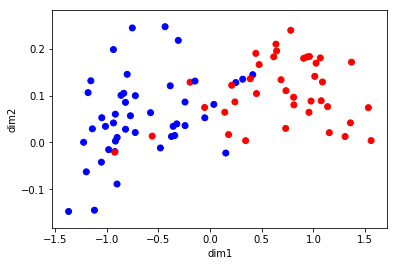

tn: 39
fp: 6
fn: 6
tp: 33

Accuracy: 0.8571428571428571
Precision: 0.8461538461538461
Recall: 0.8461538461538461
F1: 0.8461538461538461
############### Fold number 2 ###############



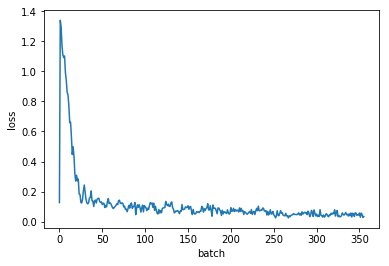

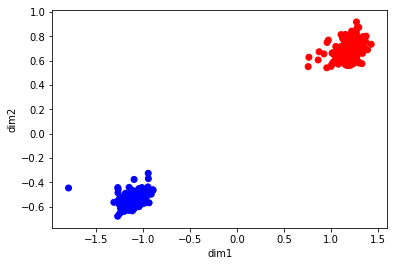

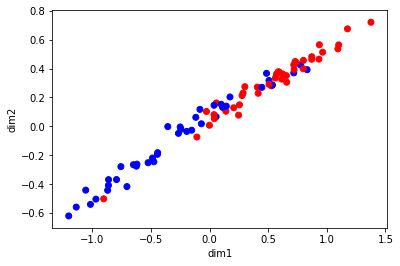

tn: 30
fp: 11
fn: 10
tp: 33

Accuracy: 0.75
Precision: 0.75
Recall: 0.7674418604651163
F1: 0.7586206896551724
############### Fold number 3 ###############



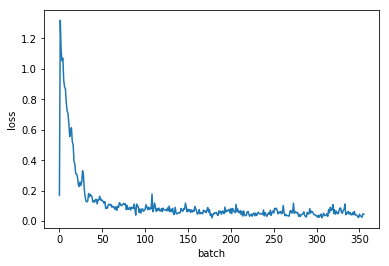

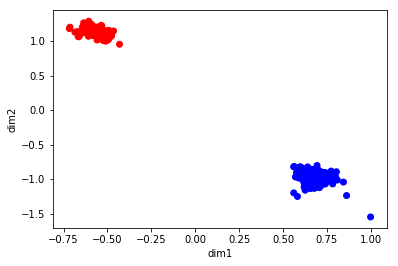

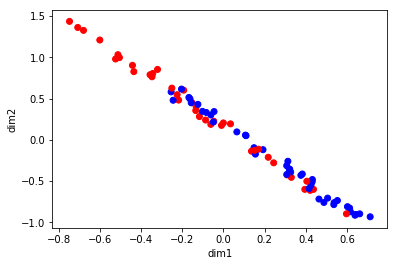

tn: 33
fp: 11
fn: 12
tp: 28

Accuracy: 0.7261904761904762
Precision: 0.717948717948718
Recall: 0.7
F1: 0.708860759493671
############### Fold number 4 ###############



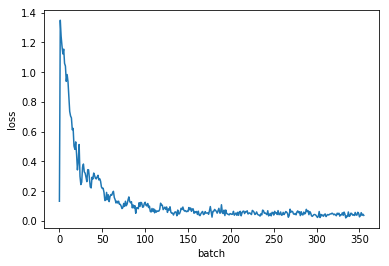

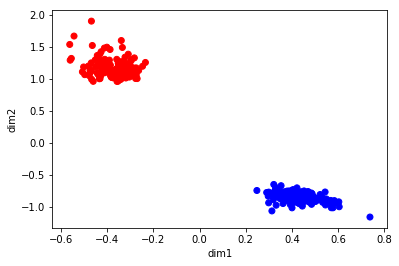

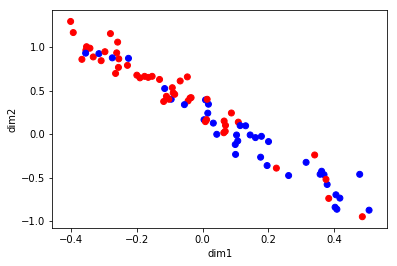

tn: 20
fp: 17
fn: 13
tp: 34

Accuracy: 0.6428571428571429
Precision: 0.6666666666666666
Recall: 0.723404255319149
F1: 0.6938775510204082
############### Fold number 5 ###############



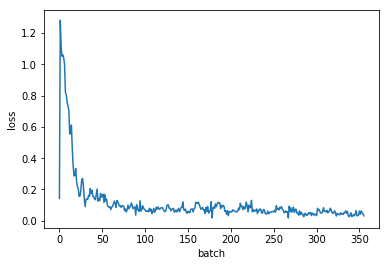

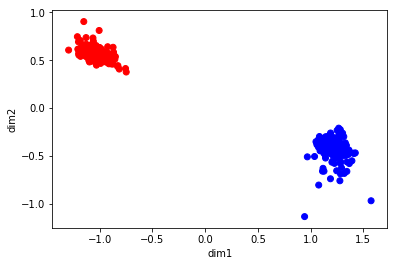

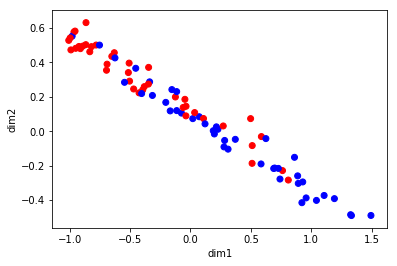

tn: 28
fp: 15
fn: 7
tp: 34

Accuracy: 0.7380952380952381
Precision: 0.6938775510204082
Recall: 0.8292682926829268
F1: 0.7555555555555555


In [39]:
model = models.SiameseModel(4, 0.0001, networks.SiameseNet(networks.Net3DChannel2()).cuda(), loss_functions.ContrastiveLoss())
k_cross_validation(model, images, 64, path)